# Modelo de classificação: XGBoost

## Carregando dados

In [12]:
import pandas as pd

# carregando dados
dados = pd.read_excel("dados/dados_escores_processados.xlsx")
dados.head()

,Ponto,PontoID,Data,Campo,Equipe,Especie01,Avaliador,Altura,EstDesenv,Invasoras,Cupins,CobertSolo,DispForr,DispFolhVerd,CondAtual,PotProd,Degrad,Manejo
0,M1001-E1-P1,750,2022-03-20,2,1,Brachiaria brizantha,Maria Eduarda Passos,17.4,3.5,4.0,2.5,5.0,3.5,3.0,2.5,3.0,3.5,2.5
1,M1001-E1-P1,750,2022-03-20,2,1,Brachiaria brizantha,João Abrão,17.4,3.5,4.5,3.0,4.5,3.5,3.5,3.0,3.5,3.5,2.5
2,M1001-E1-P1,750,2022-03-20,2,1,Brachiaria brizantha,Lara Guilarducci,17.4,3.5,4.5,3.5,5.5,3.0,2.5,3.0,3.5,3.0,3.0
3,M1001-E1-P1,750,2022-03-20,2,1,Brachiaria brizantha,Victor,17.4,3.5,3.5,3.0,5.0,3.0,3.0,3.0,3.0,3.5,2.5
4,M1001-E1-P3,748,2022-03-20,2,1,Brachiaria brizantha,João Abrão,23.0,5.0,2.0,2.0,4.0,3.0,3.0,3.5,4.0,2.5,3.5


## Preparando variáveis preditoras

In [13]:
import numpy as np

# função que calcula diferença entre max e min
def max_min_diff(x):
    return np.max(x) - np.min(x)

# separando coluna de escores
escores = [col for col in dados.columns if col not in ["Ponto", "PontoID", "Data", "Campo", "Equipe",
                                                                     "Especie01", "Avaliador"]]

# agrupando dados por id dos pontos e aplicando funções mean, min, max e max_min_diff para servirem
# como variaveis preditoras
#dados = dados.groupby("PontoID")[escores].agg([np.mean, np.min, np.max, max_min_diff])
dados = dados.groupby("PontoID")[escores].agg([np.mean])
dados.columns = [col + "_" + func for col, func in zip(dados.columns.get_level_values(0), dados.columns.get_level_values(1))]
dados.head(10)

,Altura_mean,EstDesenv_mean,Invasoras_mean,Cupins_mean,CobertSolo_mean,DispForr_mean,DispFolhVerd_mean,CondAtual_mean,PotProd_mean,Degrad_mean,Manejo_mean
PontoID,,,,,,,,,,,
0,39.84,2.975,1.833333,1.083333,4.333333,3.541667,3.875,4.291667,4.833333,1.416667,4.833333
1,7.40,1.875,6.125000,1.625000,1.625000,1.000000,1.000,1.000000,1.375000,6.375000,1.000000
3,12.50,2.375,3.000000,1.625000,2.000000,1.625000,1.250,1.250000,1.625000,4.750000,1.500000
6,15.30,2.250,3.250000,2.125000,3.625000,2.625000,2.625,2.750000,3.750000,2.875000,2.625000
9,8.90,2.000,5.250000,1.000000,1.375000,1.250000,1.125,1.250000,1.375000,6.375000,1.000000
13,7.90,1.875,5.500000,1.000000,1.750000,1.125000,1.125,1.125000,1.375000,6.125000,1.000000
16,50.30,3.250,2.625000,1.000000,2.375000,3.750000,3.500,2.250000,2.875000,3.250000,1.875000
17,7.10,1.875,4.125000,3.000000,2.125000,1.875000,1.750,1.625000,2.000000,5.000000,1.375000
18,12.70,3.125,3.125000,2.000000,4.375000,3.500000,4.000,2.875000,3.500000,2.875000,2.375000


## Carregando "rótulos" de degradação da pastagem

In [14]:
dados_classe = pd.read_excel("dados/dados_geoloc_classe.xlsx")
dados_classe.index = dados_classe["PontoID"]
dados_classe.drop(columns="PontoID", inplace=True)
dados_classe.head(10)

,Ponto,LON,LAT,REGIAO,UF,ESTADO,gridM_ID,gridG_ID,LOCCLASS,CLASS_DED
PontoID,,,,,,,,,,
750,M1001-E1-P1,-50.832922,-15.398786,Centro-Oeste,GO,Goiás,M1001,G15,outside,Degradação Moderada
748,M1001-E1-P3,-50.769860,-15.478017,Centro-Oeste,GO,Goiás,M1001,G15,inside,Degradação Baixa
713,M1009-E3-P1,-50.814776,-16.118247,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Agrícola Severa
708,M1009-E3-P2,-50.831664,-16.168822,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Baixa
706,M1009-E3-P3,-50.822681,-16.188046,Centro-Oeste,GO,Goiás,M1009,G15,outside,Degradação Moderada
705,M1009-E3-P4,-50.788635,-16.193076,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Baixa
710,M1009-E3-P6,-50.780460,-16.160647,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Moderada
711,M1009-E3-P7,-50.780371,-16.159300,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Moderada
709,M1009-E3-P8,-50.769232,-16.163611,Centro-Oeste,GO,Goiás,M1009,G15,outside,Degradação Moderada


## Join dos rótulos com os dados iniciais

In [15]:
dados = dados.join(dados_classe[["CLASS_DED"]], how="inner")
dados.head(10)

,Altura_mean,EstDesenv_mean,Invasoras_mean,Cupins_mean,CobertSolo_mean,DispForr_mean,DispFolhVerd_mean,CondAtual_mean,PotProd_mean,Degrad_mean,Manejo_mean,CLASS_DED
PontoID,,,,,,,,,,,,
1,7.4,1.875,6.125,1.625,1.625,1.000,1.000,1.000,1.375,6.375,1.000,Degradação Biológica Severa
3,12.5,2.375,3.000,1.625,2.000,1.625,1.250,1.250,1.625,4.750,1.500,Degradação Biológica Severa
6,15.3,2.250,3.250,2.125,3.625,2.625,2.625,2.750,3.750,2.875,2.625,Degradação Moderada
9,8.9,2.000,5.250,1.000,1.375,1.250,1.125,1.250,1.375,6.375,1.000,Degradação Biológica Severa
13,7.9,1.875,5.500,1.000,1.750,1.125,1.125,1.125,1.375,6.125,1.000,Degradação Biológica Severa
16,50.3,3.250,2.625,1.000,2.375,3.750,3.500,2.250,2.875,3.250,1.875,Degradação Biológica Severa
17,7.1,1.875,4.125,3.000,2.125,1.875,1.750,1.625,2.000,5.000,1.375,Degradação Biológica Severa
18,12.7,3.125,3.125,2.000,4.375,3.500,4.000,2.875,3.500,2.875,2.375,Degradação Moderada
19,6.8,2.125,1.625,2.125,3.625,2.375,1.750,2.125,2.750,3.625,1.625,Degradação Moderada


## Qual a distribuição dos rótulos?

In [16]:
dados["CLASS_DED"].value_counts()

CLASS_DED
Degradação Moderada            201
Degradação Baixa                88
Não degradada                   67
Degradação Agrícola Severa      53
Degradação Biológica Severa     51
Name: count, dtype: int64

## Preparando X_train, X_test, y_train, y_test

Variável de saída: y

In [17]:
y = dados["CLASS_DED"].map({"Não degradada": 0, "Degradação Baixa": 1,
                           "Degradação Moderada": 2, "Degradação Agrícola Severa": 3,
                           "Degradação Biológica Severa": 4}).values
y[:10]

array([4, 4, 2, 4, 4, 4, 4, 2, 2, 1])

Variável de entrada: X

In [18]:
#X = dados.drop(columns=["CLASS_DED"]).values
X = dados[["CobertSolo_mean", "Invasoras_mean", "PotProd_mean"]].values
X[:, :10]

array([[1.625, 6.125, 1.375],
       [2.   , 3.   , 1.625],
       [3.625, 3.25 , 3.75 ],
       ...,
       [4.25 , 1.375, 4.375],
       [4.5  , 2.125, 4.   ],
       [5.   , 4.125, 3.25 ]])

Divisão dos dados em dados de treino e dados de teste.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=667)

print(f"Total de pontos reservados para treino: {len(X_train)}")
print(f"Total de pontos reservados para teste: {len(X_test)}")

Total de pontos reservados para treino: 322
Total de pontos reservados para teste: 138


## Otimização de hiperparâmetros e treinamento do modelo de classificação

In [20]:
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable


Para a tunagem de hiperparâmetros, será utilizado o otimizador de Bayes, que faz uso da regra de Bayes para buscar a melhor combinação de hiperparâmetros com base nos resultados provenientes de validação cruzada. Usaremos K-Fold estratificado (para manter as classes balanceadas) com K = 5, para termos uma boa estatística.

## Será que uma simples árvore de decisão dá conta do recado?

In [24]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

simple_model = DecisionTreeClassifier(max_depth=4, random_state=700)

simple_model.fit(X_train, y_train)
print(classification_report(y_test, simple_model.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.7407    1.0000    0.8511        20
           1     0.8462    0.8148    0.8302        27
           2     1.0000    0.9000    0.9474        60
           3     1.0000    1.0000    1.0000        16
           4     1.0000    1.0000    1.0000        15

    accuracy                         0.9203       138
   macro avg     0.9174    0.9430    0.9257       138
weighted avg     0.9323    0.9203    0.9223       138



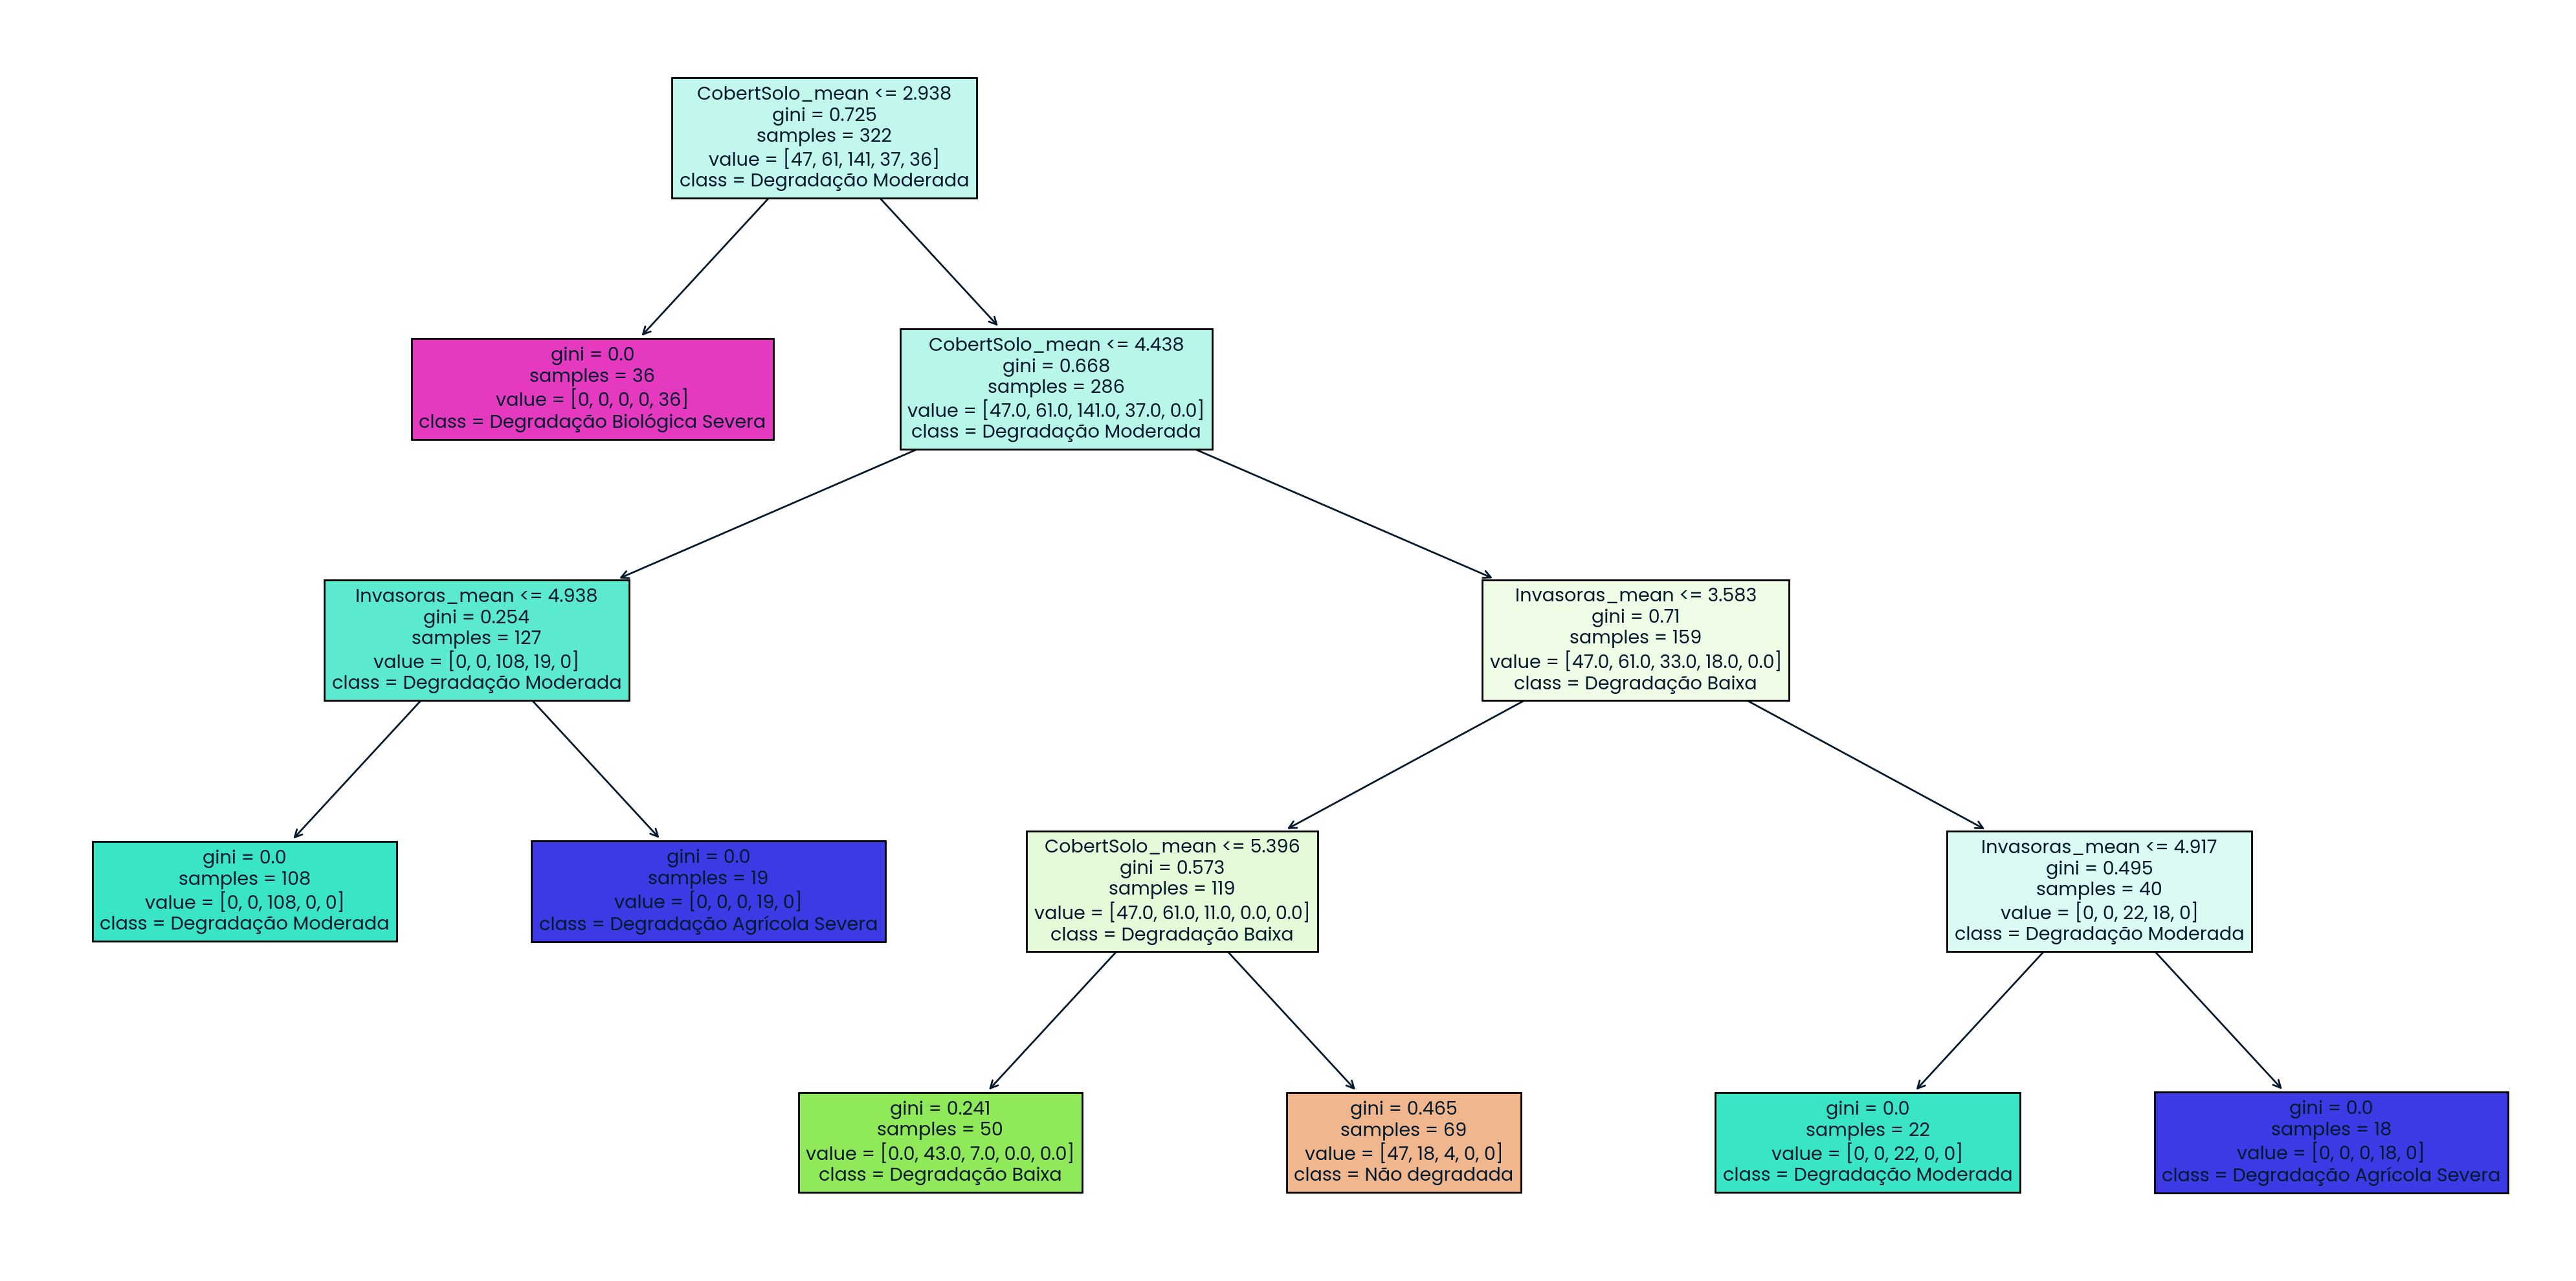

In [25]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(simple_model, filled=True, feature_names=["CobertSolo_mean", "Invasoras_mean", "PotProd_mean"], class_names=["Não degradada", "Degradação Baixa", "Degradação Moderada", "Degradação Agrícola Severa", "Degradação Biológica Severa"])
plt.tight_layout()
plt.savefig("simple_model.png", dpi=600)
plt.show()